# Ressources

* https://www.tensorflow.org/lite/tutorials/model_maker_object_detection
* https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/object_detector
* https://coral.ai/docs/edgetpu/retrain-detection/
* https://github.com/google-coral/tflite/tree/master/python/examples/detection
* https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi

In [1]:
%%shell

nvidia-smi

Thu Aug 26 14:35:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%shell 

# see https://discuss.tensorflow.org/t/invalidargumenterror-required-broadcastable-shapes-op-mul/3824/4
# pip install tensorflow==2.5.0
# pip install tflite-model-maker
pip install tflite-model-maker-nightly

     |████████████████████████████████| 620 kB 12.3 MB/s 
     |████████████████████████████████| 1.1 MB 43.0 MB/s 
     |████████████████████████████████| 3.4 MB 44.4 MB/s 
     |████████████████████████████████| 1.2 MB 39.6 MB/s 
     |████████████████████████████████| 6.3 MB 49.7 MB/s 
     |████████████████████████████████| 87 kB 7.0 MB/s 
     |████████████████████████████████| 120 kB 47.4 MB/s 
     |████████████████████████████████| 211 kB 52.7 MB/s 
     |████████████████████████████████| 840 kB 39.2 MB/s 
     |████████████████████████████████| 1.1 MB 45.9 MB/s 
     |████████████████████████████████| 636 kB 48.6 MB/s 
     |████████████████████████████████| 25.3 MB 78 kB/s 
     |████████████████████████████████| 37.1 MB 47 kB/s 
     |████████████████████████████████| 1.1 MB 33.9 MB/s 
     |████████████████████████████████| 352 kB 49.3 MB/s 
     |████████████████████████████████| 99 kB 9.7 MB/s 
     |████████████████████████████████| 200 kB 51.7 MB/s 
  Created wheel for 

# Installation du projet `bfc` et accès aux données

Les login et mot de passe sont nécessaires pour accéder à des repos privés à partir de Google/Colab. Cela ne serait pas le cas en accès public.

In [3]:
import os
from getpass import getpass

In [4]:
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password

GitHub user··········
GitHub password··········


In [5]:
%%shell

git clone https://$GITHUB_AUTH@github.com/tibocour/IA.git

Cloning into 'IA'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 38 (delta 9), reused 36 (delta 7), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [6]:
%%shell

rm -rf Annotations images
mkdir train
mkdir valid
unzip -q IA/data/train_megots150images.zip -d train
unzip -q IA/data/valid_megots150images.zip -d valid

# Préparation des données [DEPRECATED]

~~Le format `Pascal VOC` de `Label Studio` est encodé en `utf-8` ce qui n'est pas supporté par `tensorflow-lite`. D'autre part, le label `filename` des fichiers `xml` ne contient pas l'extension `.jpg`.~~

In [ ]:
# import os

In [ ]:
# os.makedirs("annotations", exist_ok=True)

In [ ]:
# for filename in os.listdir("Annotations"):
#    with open(os.path.join("Annotations", filename), 'r') as file :
#        filedata = file.read()

#    filedata = filedata.replace(' encoding="utf-8"', "")
#    filedata = filedata.replace("</filename>", ".jpg</filename>")

#    with open(os.path.join("annotations", filename), 'w') as file:
#        file.write(filedata)

~~On effectue une répartition aléatoire des données 80% pour l'entrainement et le reste pour la validation.~~

> ~~C'est vraiment grossier. Dans le cas d'une détection à plusieurs classes, il convient d'avoir une stratégie plus adaptée pour ne pas sur / sous représenter des catégories.~~

In [ ]:
# filenames = [os.path.splitext(filename)[0] for filename in os.listdir("Annotations")]

In [ ]:
# import random

In [ ]:
# random.shuffle(filenames)

In [ ]:
# train_size = int(len(filenames) * 0.8)

In [ ]:
# train_filenames = filenames[:train_size]
# valid_filenames = filenames[train_size:]

# Apprentissage par transfer learning

In [9]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [10]:
from tflite_model_maker import object_detector

In [11]:
train_data = object_detector.DataLoader.from_pascal_voc(
    images_dir="train/images",
    annotations_dir="train/annotations",
    label_map=["megot"]
)

INFO:tensorflow:Cache will be stored in /tmp/tmpp0uj7sr3 with prefix filename fd2c112752054ea1fcebcf49d7779205. Cache_prefix is /tmp/tmpp0uj7sr3/fd2c112752054ea1fcebcf49d7779205
INFO:tensorflow:On image 0
INFO:tensorflow:On image 100
INFO:tensorflow:On image 200
INFO:tensorflow:On image 300
INFO:tensorflow:On image 400
INFO:tensorflow:On image 500
INFO:tensorflow:On image 600
INFO:tensorflow:On image 700
INFO:tensorflow:On image 800
INFO:tensorflow:On image 900
INFO:tensorflow:On image 1000
INFO:tensorflow:On image 1100
INFO:tensorflow:On image 1200


In [12]:
valid_data = object_detector.DataLoader.from_pascal_voc(
    images_dir="valid/images",
    annotations_dir="valid/annotations",
    label_map=["megot"]
)

INFO:tensorflow:Cache will be stored in /tmp/tmpcm_u6ely with prefix filename fd2c112752054ea1fcebcf49d7779205. Cache_prefix is /tmp/tmpcm_u6ely/fd2c112752054ea1fcebcf49d7779205
INFO:tensorflow:On image 0


In [13]:
len(train_data), len(valid_data)

(1287, 30)

Architecture de detection : [EfficientDet](https://arxiv.org/pdf/1911.09070.pdf)
voir également [ici](https://ai.googleblog.com/2020/04/efficientdet-towards-scalable-and.html) pour les détails.

In [14]:
spec = object_detector.EfficientDetLite0Spec()

In [15]:
model = object_detector.create(train_data=train_data,
                               model_spec=spec,
                               validation_data=valid_data,
                               epochs=50,
                               batch_size=10,
                               train_whole_model=True)

INFO:tensorflow:Retraining the models...
Epoch 1/50
128/128 [==============================] - 128s 502ms/step - det_loss: 0.7856 - cls_loss: 0.4179 - box_loss: 0.0074 - reg_l2_loss: 0.0630 - loss: 0.8486 - learning_rate: 0.0102 - gradient_norm: 2.5633 - val_det_loss: 0.6861 - val_cls_loss: 0.3128 - val_box_loss: 0.0075 - val_reg_l2_loss: 0.0631 - val_loss: 0.7492
Epoch 2/50
128/128 [==============================] - 61s 474ms/step - det_loss: 0.3268 - cls_loss: 0.1807 - box_loss: 0.0029 - reg_l2_loss: 0.0632 - loss: 0.3900 - learning_rate: 0.0125 - gradient_norm: 2.4834 - val_det_loss: 0.5386 - val_cls_loss: 0.3003 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0633 - val_loss: 0.6019
Epoch 3/50
128/128 [==============================] - 60s 473ms/step - det_loss: 0.2773 - cls_loss: 0.1598 - box_loss: 0.0023 - reg_l2_loss: 0.0633 - loss: 0.3406 - learning_rate: 0.0124 - gradient_norm: 2.1946 - val_det_loss: 0.3789 - val_cls_loss: 0.2189 - val_box_loss: 0.0032 - val_reg_l2_loss: 0.0634 - 

In [16]:
model.evaluate(train_data)

21/21 [==============================] - 41s 1s/step

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(128700, 7)
0/128700
DONE (t=1.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.77s).
Accumulating evaluation results...
DONE (t=0.53s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.901
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.901
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.923
 Average Recall     (AR) @[ IoU=0.50:

{'AP': 0.9012645,
 'AP50': 1.0,
 'AP75': 1.0,
 'AP_/megot': 0.9012645,
 'APl': 0.901353,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.9501166,
 'ARm': -1.0,
 'ARmax1': 0.9228438,
 'ARmax10': 0.94817406,
 'ARmax100': 0.9501166,
 'ARs': -1.0}

In [17]:
model.evaluate(valid_data)

1/1 [==============================] - 7s 7s/step

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(3000, 7)
0/3000
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.794
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.944
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.820
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

{'AP': 0.7942807,
 'AP50': 1.0,
 'AP75': 0.9438944,
 'AP_/megot': 0.7942807,
 'APl': 0.7943406,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.8433333,
 'ARm': -1.0,
 'ARmax1': 0.82,
 'ARmax10': 0.83666664,
 'ARmax100': 0.8433333,
 'ARs': -1.0}

In [18]:
from tflite_model_maker.config import ExportFormat

In [19]:
model.export(export_dir='.',
             tflite_filename='efficientdet-lite-bfc.tflite',
             label_filename='bfc-labels.txt',
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

INFO:tensorflow:Assets written to: /tmp/tmpnmeym94o/assets


INFO:tensorflow:Assets written to: /tmp/tmpnmeym94o/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpa43990cm/labelmap.txt.


INFO:tensorflow:Saving labels in /tmp/tmpa43990cm/labelmap.txt.


INFO:tensorflow:Finished populating metadata and associated file to the model:


INFO:tensorflow:Finished populating metadata and associated file to the model:


INFO:tensorflow:./efficientdet-lite-bfc.tflite


INFO:tensorflow:./efficientdet-lite-bfc.tflite


INFO:tensorflow:The associated file that has been been packed to the model is:


INFO:tensorflow:The associated file that has been been packed to the model is:


INFO:tensorflow:['labelmap.txt']


INFO:tensorflow:['labelmap.txt']


INFO:tensorflow:TensorFlow Lite model exported successfully: ./efficientdet-lite-bfc.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./efficientdet-lite-bfc.tflite


INFO:tensorflow:Saving labels in ./bfc-labels.txt.


INFO:tensorflow:Saving labels in ./bfc-labels.txt.


In [21]:
model.evaluate_tflite('efficientdet-lite-bfc.tflite', train_data)

1287/1287 [==============================] - 3456s 3s/step

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(32175, 7)
0/32175
DONE (t=0.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.72s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.887
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.887
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.919
 Average Recall     (AR) @[ IoU=0

{'AP': 0.8870405,
 'AP50': 1.0,
 'AP75': 1.0,
 'AP_/megot': 0.8870405,
 'APl': 0.8870405,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.9190365,
 'ARm': -1.0,
 'ARmax1': 0.9190365,
 'ARmax10': 0.9190365,
 'ARmax100': 0.9190365,
 'ARs': -1.0}

In [22]:
model.evaluate_tflite('efficientdet-lite-bfc.tflite', valid_data)

30/30 [==============================] - 81s 3s/step

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(750, 7)
0/750
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.798
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.937
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.798
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.823
 Average Recall     (AR) @[ IoU=0.50:0.95 |

{'AP': 0.7977346,
 'AP50': 1.0,
 'AP75': 0.9372937,
 'AP_/megot': 0.7977346,
 'APl': 0.7977346,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.8233333,
 'ARm': -1.0,
 'ARmax1': 0.8233333,
 'ARmax10': 0.8233333,
 'ARmax100': 0.8233333,
 'ARs': -1.0}

# Inférence

A partir d'ici, la librairie `tflite-model-maker` est inutile. On utilise nativement `tflite`.

Le code suivant est une alternative à l'outillage proposé pour le Coral TPU, voir [ici](https://github.com/google-coral/tflite/tree/master/python/examples/detection).

In [23]:
import numpy as np
import cv2

from PIL import Image

# Load the labels into a list
classes = ["megot"]

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 1)
  classes = get_output_tensor(interpreter, 3)
  scores = get_output_tensor(interpreter, 0)
  count = int(get_output_tensor(interpreter, 2))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

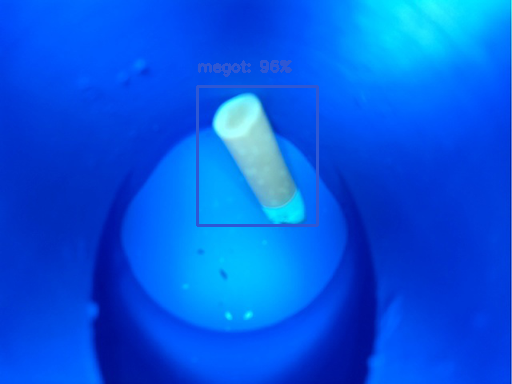

In [26]:
im = Image.open("valid/images/1608644746.jpg")
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save("/tmp/image.png", 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="efficientdet-lite-bfc.tflite")
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    "/tmp/image.png",
    interpreter,
    threshold=0.5
)

# Show the detection result
Image.fromarray(detection_result_image)